This is a file with code for the following tasks:

Data Collection \
Articles related to anxiety and depression published between 2004 and 2024 from:
- The New York Times 
- The Guardian 

Data Cleaning

Data Analysis

- Trends Analysis
- Frequency of COVID-19 articles during 2020
- Words frequencies 
- N-grams
- Sentiment Analysis

In [ ]:
import requests
import time
import pandas as pd
import json
import csv
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy import stats
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from afinn import Afinn

# Part I. Data Collection



### Collection of New York Times articles (NATASHA)

In [ ]:
#Basic details needed to interact with The New York Times API
api_key = "" #deleted after interaction with the API
base_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

def collect_articles_NYT(word, output_file_name):
    '''
    Interact with The New York Times API to collect articles' data. Restrict
    the search to those articles containing the given word in the headline.
    Lastly, generate a json file to store the data so it can be easily
    retrieved later without needing to make requests every time.

    Inputs:
        word (str): word of interest for the query
        output_file_name (str): desired name for the json file to be created

    Outputs:
        json file
    '''

    articles = {}

    for year in range(2004,2025):

        year_data = []

        #Since the API only retrieves 10 results per query, we have to loop
        #through different pages. The range 0-100 is set up since it is the
        #maximum number of pages that can be requested.
        for page in range(0,100):

            begindate = "{}0101".format(year)
            enddate = "{}1231".format(year)
            nyt_params = {"q": word, "fq": f'headline:{word}',
                        "begin_date": begindate, "end_date": enddate,
                        "page": page, "api-key": api_key}

            response = requests.get(base_url, params= nyt_params)
            page_data = response.json()
            #Time sleep of 14 because the limit is 5 requests per minute
            time.sleep(14)

            #After collecting all available data, subsequent pages retrieve
            #empty results. For that reason, we can break the loop when pages
            #are no longer useful. It also avoids making unnecessary and
            #time-consuming requests

            if len(page_data["response"]["docs"]) == 0:
                break

            year_data += page_data["response"]["docs"]

        articles[year] = year_data

    #Export the dictionary to a JSON file to save it locally to avoid needing
    #to make requests every time we work on the project.
    with open(output_file_name, 'w') as json_file:
        json.dump(articles, json_file, indent=4)


#Call function to retrieve NYT articles related to anxiety and depression

#collect_articles_NYT("anxiety", "anxiety_articles_NYT.json")
#collect_articles_NYT("depression", "depression_articles_NYT.json")

### Collection of The Guardian's articles (YUE)

In [ ]:
#According to chatgpt's suggestion, I added a while loop to loop through each
#page.
def search_guardian_api(api_key, query, from_date, to_date):
    """
    Interact with The Guardian API. Use the given parameters to extract
    articles with desired features.
    Inputs:
      - api_key (str): API key needed to interact with API
      - query (str): word of interest
      - from_date (str): first day of timeframe of interest
      - to_date (str): the last day of timeframe of interest
    Outputs:
      - (list) a list of articles data
    """
    base_url = "https://content.guardianapis.com/search"
    params = {
        'api-key': api_key,
        'q': query,
        'order-by': 'newest',
        'from-date': from_date,
        'to-date': to_date,
        'show-fields': 'headline,bodyText,webPublicationDate',
        'section': 'society' or 'wellness'
    }

    all_articles = []
    page = 1
    total_articles = float('inf')  # Initialize to infinity

#By using pagination logic with a while loop, we update the page parameter in
#each API request until we retrieve all relevant articles.
    while len(all_articles) < total_articles:
        params['page'] = page
        response = requests.get(base_url, params=params)
        #Time sleep of 1 because The Guardian allows one call per second
        time.sleep(1)

        if response.status_code == 200:
            data = response.json()
            articles = data.get('response', {}).get('results', [])
            total_articles = data.get('response', {}).get('total', 0)

            for article in articles:
                headline = article.get('fields', {}).get('headline', '')
                publication_date = article.get('webPublicationDate', '')
                body_text = article.get('fields', {}).get('bodyText', '')
                all_articles.append({'Headline': headline,
                 'Publication Date': publication_date, 'Body Text': body_text})

            page += 1
        else:
            print(f"Error: {response.status_code}, {response.text}")
            break

    return all_articles

api_key = ' ' #deleted after collection
from_date = '2004-01-01'
to_date = '2024-02-07'

#Call to retrieve anxiety articles
query = 'anxiety'
#anxiety_articles = search_guardian_api(api_key, query, from_date, to_date)
#df = pd.DataFrame(anxiety_articles)
#df.to_csv('anxiety_articles.csv', index=False)

#Call to retrieve depression articles
query = 'depression'
#depression_articles = search_guardian_api(api_key, query, from_date, to_date)
#df = pd.DataFrame(depression_articles)
#df.to_csv('depression_articles.csv', index=False)

### Collecting total number of articles published (yearly) on The New York Times for the past 20 years (NATASHA) to perform analysis of proportion

In [ ]:
total_n_nyt = {}

for year in range(2004,2025):

    begindate = "{}0101".format(year)
    enddate = "{}1231".format(year)
    nyt_params = { "begin_date": begindate, "end_date": enddate,
                   "api-key": api_key}

    #response = requests.get(base_url, params= nyt_params)
    #data = response.json()

    #Extract number of total articles from the metadata. ("Hits" refers to
    #total number of results
    #total_n_articles = data["response"]["meta"]["hits"]
    #time.sleep(12)

    #total_n_nyt[year] = total_n_articles

#with open("yearly_n_all_nyt", 'w') as json_file:
    #json.dump(total_n_nyt, json_file, indent=4)

# Part II. Data Cleaning

### Create initial dataframes for NYT articles (NATASHA)

In [ ]:
def create_df_NYT_articles(jsonfilepath):
    '''
    Given a JSON file containing NYT's articles data, create a data frame that
    contains useful information

    Inputs:
        jsonfilepath (str): name of the file preceeded by its path

    Returns:
        DataFrame containing information of the articles (year published,
        specific date, headlines and abstracts)
    '''

    #Open json file as a python dictinary
    with open(jsonfilepath, "r") as json_file:
        dictdata = json.load(json_file)

    #Loop through each item in the dictionary to get the most relevant information
    #of the articles and store it in a dataframe

    cols = {"year" : [], "specific_date": [], "section": [], 'subsection': [],
                                                 'headlines':[], 'abstracts':[]}

    for year_x in range(2004,2025):
        year_data = dictdata[str(year_x)]
        for index, article in enumerate(year_data):


            cols["year"].append(year_x)
            cols['specific_date'].append(article['pub_date'])
            cols['headlines'].append(article["headline"]["main"])
            cols['abstracts'].append(article['abstract'])

            try:
                cols['section'].append(article["section_name"])
            except:
                cols['section'].append(None)

            try:
                cols['subsection'].append(article["subsection_name"])
            except:
                cols['subsection'].append(None)

    df = pd.DataFrame(cols)
    return df

#Call function to create data frame for NYT's anxiety articles
anx_nyt_df = create_df_NYT_articles("nyt_articles_raw/anxiety_articles_NYT.json")

#Create dataframe for NYT's depression articles
dep_nyt_df = create_df_NYT_articles("nyt_articles_raw/depression_articles_NYT.json")


In [399]:
dep_nyt_df

,year,specific_date,section,subsection,headlines,abstracts
0,2004,2004-12-10T05:00:00+0000,U.S.,None,Study Pursues a Genetic Link to Depression,Scientists at Duke University find genetic var...
1,2004,2004-12-17T05:00:00+0000,U.S.,None,Study Suggests Way to Predict Whom Antidepress...,Harvard and UCLA researchers find that common ...
2,2004,2004-12-07T05:00:00+0000,Health,None,Tracking Stress and Depression Back to the Womb,Studies indicate that stress and depression in...
3,2004,2004-09-12T05:00:00+0000,Business Day,None,"Depression, a Frequent Visitor to Wall St.",Rate of chronic depression seems to be high am...
4,2004,2004-08-25T05:00:00+0000,U.S.,None,New Therapy On Depression Finds Phone Is Effec...,Study reported in Journal of the American Medi...
...,...,...,...,...,...,...
711,2023,2023-08-22T07:06:10+0000,U.S.,None,Harold Is Downgraded to Tropical Depression Af...,The storm unleashed heavy rainfall that caused...
712,2023,2023-07-13T18:07:54+0000,Opinion,Letters,Shining a Light on Postpartum Depression,A psychiatrist and a new mother discuss the co...
713,2024,2024-01-10T23:30:06+0000,Health,None,Women With Depression During or After Pregnanc...,Two studies concluded that depression that beg...
714,2024,2024-02-06T10:03:28+0000,U.S.,None,A Rising Democratic Star Shares Her Mental Hea...,"Lina Hidalgo, who became Houston’s top executi..."


### NYT data cleaning (JAYDA)

In [ ]:
# Create function to clean nyt data frame
def clean_nyt_df(df, anxiety_depression_ID):
    """
    Cleans NYT data frame with added source id, anxiety or depression id,
    covid time frames and tokenized titles and abstracts

    Input:
    - df: (Pandas DataFrame) raw NYT data frame
    - anxiety_depression_ID: (integer) of 1 or 0

    Output: cleaned data frame
    """
    # filter out Great Depression articles
    new_df = df.drop(df[df['headlines'].str.contains("Great Depression")].index)

    # add NYT id
    new_df["Sources"] = 0

    # add anxiety_depression_ID
    new_df["Anxiety or Depression"] = anxiety_depression_ID

    # standardize date format
    new_df["specific_date"] = new_df["specific_date"].astype(str)
    new_df["date"] = new_df["specific_date"].str.extract(r"(.{10})T", expand=True)

    # make time frame variable, ask chatgbt how to compare dates before and 
    #after and set to deisgnated values
    new_df["date"] = pd.to_datetime(new_df["date"])

    pre = pd.to_datetime("2020-03-11")
    post = pd.to_datetime("2023-05-11")

    time_frames = [
        (new_df["date"] < pre),
        (new_df["date"] > post)]

    values = [0, 2]

    new_df['Time frame'] = np.select(time_frames, values, default=1)

    # make month and day variables
    new_df["Month"] = new_df["specific_date"].str.extract(r"-([0-9]{2})", 
                                                          expand=True)
    new_df["Date"] = new_df["specific_date"].str.extract(r"([0-9]{2})T", 
                                                         expand=True)
    new_df["Year"] = new_df["year"]

    # clean headlines and abstracts
    new_df["Title"]  = [re.sub(r'[^\w\s]', '', i).lower() for i in new_df["headlines"]]
    new_df["Abstract"]  = [re.sub(r'[^\w\s]', '', i).lower() for i in new_df["abstracts"]]
    # ask chatgbt the regex to get rid of punctuation

    return new_df

In [ ]:
clean_nyt_anx = clean_nyt_df(anx_nyt_df, 0)
clean_nyt_dep = clean_nyt_df(dep_nyt_df, 1)

In [ ]:
# combine data frames and filter desired columns
filter = ["Sources", "Month", "Date", "Year", "Anxiety or Depression", "Title",
                                                       "Abstract", "Time frame"]
clean_nyt = pd.concat([clean_nyt_anx, clean_nyt_dep], axis=0)[filter]

# perform deeper cleaning after realizing we had more dirty data

excluded_topics_lst = ["great depression", "economy", "economics", "stocks",
                   "voting", "politics", "election", "climate", "fire",
                   "economic", "market", "trump", "inflation"]

excluded_topics = '|'.join(excluded_topics_lst)

clean_nyt = clean_nyt.drop(clean_nyt[clean_nyt['Title'].str.contains(excluded_topics)].index)
clean_nyt = clean_nyt.drop(clean_nyt[clean_nyt['Abstract'].str.contains(excluded_topics)].index)

#clean_nyt.to_csv("cleaned_articles/clean_nyt", sep=',', index=False)

In [400]:
clean_nyt.head()

,Sources,Month,Date,Year,Anxiety or Depression,Title,Abstract,Time frame
0,0,03,14,2004,0,high anxiety,james glanz article on safety precautions bein...,0
1,0,08,22,2004,0,status anxiety,money fame and influence may be valued more as...,0
2,0,12,06,2004,0,anxiety for an american family,interview with carolyn richard adairsville ga ...,0
4,0,02,29,2004,0,high velocity some anxiety,new york yankees pitcher kevin brown prepares ...,0
6,0,04,01,2004,0,laughter and anxiety at the tyco trial,juror number 479yearold womanin tyco internati...,0


### The Guardian data cleaning (KEXIN)

In [ ]:
anxiety_df = pd.read_csv('guardian_articles_raw/anxiety_articles_guardian.csv',
                         low_memory=False)
depression_df = pd.read_csv('guardian_articles_raw/depression_articles_guardian.csv',
                            low_memory=False)

anxiety_df['Anxiety or Depression'] = 0  # 0 for anxiety articles
depression_df['Anxiety or Depression'] = 1  # 1 for depression articles

combined_df = pd.concat([anxiety_df, depression_df], axis = 0, ignore_index=True)

combined_df.rename(columns={'Headline': 'Title'}, inplace=True)

combined_df['Sources'] = 1 # 1 for The Guardian

# Convert 'Publication Date' to datetime and remove rows with invalid or missing dates
combined_df['Publication Date'] = pd.to_datetime(combined_df['Publication Date']
                                                 , errors='coerce')
combined_df = combined_df.dropna(subset=['Publication Date'])

# Remove timezone information from 'Publication Date'
combined_df['Publication Date'] = combined_df['Publication Date'].dt.tz_localize(None)

# Extract 'Month', 'Date', and 'Year'
combined_df['Month'] = combined_df['Publication Date'].dt.month
combined_df['Date'] = combined_df['Publication Date'].dt.day
combined_df['Year'] = combined_df['Publication Date'].dt.year

# Define the criteria for 'Time frame'
pre_date = datetime.strptime('2020-03-11', '%Y-%m-%d')
post_date = datetime.strptime('2023-05-11', '%Y-%m-%d')

# Function to determine the 'Time frame'
def determine_time_frame(row):
    """
    Create a new column for the data frame that specifies if an article was
    published before covid, during covid or after covid

    Input:
    - row (DataFrame's row)
    Output:
    - (int) coding of timeframe for new column
    """

    if row['Publication Date'] < pre_date:
        return 0  # Pre
    elif row['Publication Date'] <= post_date:
        return 1  # During
    else:
        return 2  # Post

# Apply the function to set the 'Time frame'
combined_df['Time frame'] = combined_df.apply(determine_time_frame, axis=1)

# Remove the original 'Publication Date' column
combined_df.drop(columns=['Publication Date'], inplace=True)

def clean_text(text):
    """
    Cleans text

    Input:
      - (str) raw text

    Output:
      - (str) cleaned text

    """
    if isinstance(text, str):
        text = text.lower() # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    else:
        text = "" # Replace missing values with empty strings
    return text

combined_df['Title'] = combined_df['Title'].apply(clean_text)
combined_df['Body Text'] = combined_df['Body Text'].apply(clean_text)

combined_df.dropna(subset=['Title', 'Body Text'], inplace=True)

combined_df = combined_df[['Sources', 'Month', 'Date', 'Year',
                           'Anxiety or Depression', 'Title',
                           'Body Text', 'Time frame']]


#Remove duplicates from The Guardian
#See counts before removing
print(len(combined_df))
print(combined_df['Anxiety or Depression'].value_counts())

#create mask to find duplicates in df
duplicates = combined_df.duplicated(subset='Title')

# create mask to find if an article is a duplicate (to find original articles)
mask = combined_df['Title'].isin(combined_df[duplicates]['Title'].tolist())

# set duplicate articles to 2 in 'Anxiety or Depression' column
combined_df.loc[mask, 'Anxiety or Depression'] = 2

clean_guardian = combined_df.drop_duplicates('Title')

#See counts after removing
print(len(clean_guardian))
print(clean_guardian['Anxiety or Depression'].value_counts())

clean_guardian.to_csv('cleaned_articles/clean_guardian.csv', index=False)

In [401]:
clean_guardian.head()

,Sources,Month,Date,Year,Anxiety or Depression,Title,Body Text,Time frame
0,1,2,7,2024,2,childrens emergency mental health referrals in...,the number of children referred to emergency m...,2
1,1,2,5,2024,2,women with polycystic ovary syndrome may have ...,women diagnosed with polycystic ovary syndrome...,2
2,1,2,4,2024,2,rage would bubble out of nowhere my battle wit...,the first time i learned anything useful about...,2
3,1,2,2,2024,2,nearly a third of uk secondary pupils avoid sc...,almost three in 10 secondary pupils are avoidi...,2
4,1,2,2,2024,0,i plan fewer outings britons on the scarcity o...,urinating in public made the headlines this we...,2


In [ ]:
#Merge two newspapers
combined = pd.concat([clean_guardian, clean_nyt], axis=0, ignore_index=True)
combined.to_csv('cleaned_articles/combined.csv', index=False)

In [ ]:
#Have variables that separate into newspapers and dataframes
df_nyt_pre_covid = clean_nyt[(clean_nyt["Time frame"] == 0)]
df_nyt_during_covid = clean_nyt[(clean_nyt["Time frame"] == 1)]
df_nyt_post_covid = clean_nyt[(clean_nyt["Time frame"] == 2)]

df_g_pre_covid = clean_guardian[(clean_guardian["Time frame"] == 0)]
df_g_during_covid = clean_guardian[(clean_guardian["Time frame"] == 1)]
df_g_post_covid = clean_guardian[(clean_guardian["Time frame"] == 2)]

# Part III. Data Analysis and Visualization

### Trend Analysis (YUE):

We checked the proportion of anxiety and depression articles published each year from 2004 to 2023. We got rid of 2024, because only 2 months passed. We use proportion because we want to normalize the data and check for variations in the total number of articles published each year. Then, we see frequencies in 2020 separately.

*The function below check the total number of ALL articles published by The Guardian each year, so we need to call the API again.*

In [ ]:
def count_articles_by_year(api_key, from_date, to_date):
    '''
    Interact with The Guardian API. Use the given parameters to extract
    articles with desired features, here we want the count of all published
    articles by The Guardian
    Inputs:
      - api_key (str): API key needed to interact with API
      - query (str): word of interest
      - from_date (str): first day of timeframe of interest
      - to_date (str): the last day of timeframe of interest
    Outputs:
      - (dictionary) a dictionary of all articles count by years

    '''
    base_url = "https://content.guardianapis.com/search"

    total_articles_by_year = {}

    start_year = int(from_date[:4])
    end_year = int(to_date[:4]) + 1
    #set year range
    for year in range(start_year, end_year):
        year_from_date = f"{year}-01-01"
        year_to_date = f"{year}-12-31"

        params = {
            'api-key': api_key,
            'from-date': year_from_date,
            'to-date': year_to_date,
            'page-size': 1,
        }

        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()
            total = data.get('response', {}).get('total', 0)
            total_articles_by_year[str(year)] = total
        else:
            print(f"Error: {response.status_code}, {response.text}")
            total_articles_by_year[str(year)] = 0

    return total_articles_by_year

api_key = '' #deleted after data collection
from_date = '2004-01-01'
to_date = '2024-02-07'

#total_articles_by_year = count_articles_by_year(api_key, from_date, to_date)

#for year, count in total_articles_by_year.items():
    #print(f"Year: {year}, Total Articles: {count}")

#df = pd.DataFrame(list(total_articles_by_year.items()), columns=['Year',
                                                    # 'Total Articles'])
#df.to_csv('total_articles_by_year.csv', index=False)

Anxiety articles proportion for Guardian

In [402]:
df_anxiety_articles = combined[combined['Anxiety or Depression'].isin([0,2])][combined['Sources']==1].groupby("Year").size().reset_index(name='Total Anxiety Articles')
df_total_articles = pd.read_csv('all_articles_counts/total_articles_by_year_guardian.csv')

# Merge the DataFrames on 'Year' column
df_proportion_anxiety = pd.merge(df_total_articles, df_anxiety_articles, on='Year',
                                                                    how='left')

# Calculate the proportions of anxiety articles for each year
df_proportion_anxiety['Proportion'] = (df_proportion_anxiety['Total Anxiety Articles'] /
                                    df_proportion_anxiety['Total Articles'])
df_proportion_anxiety

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1707/1081914658.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_anxiety_articles = combined[combined['Anxiety or Depression'].isin([0,2])][combined['Sources']==1].groupby("Year").size().reset_index(name='Total Anxiety Articles')


,Year,Total Articles,Total Anxiety Articles,Proportion
0,2004,97873,148,0.001512
1,2005,99939,145,0.001451
2,2006,108381,105,0.000969
3,2007,125860,93,0.000739
4,2008,144090,100,0.000694
5,2009,122035,89,0.000729
6,2010,108920,69,0.000633
7,2011,118663,135,0.001138
8,2012,120930,78,0.000645
9,2013,125551,113,0.000900


Depression articles proportion for Guardian

In [ ]:
df_depression = combined[combined['Anxiety or Depression'].isin([1,2])][combined['Sources']==1].groupby("Year").size().reset_index(name='Total Depression Articles')

# Merge the DataFrames on 'Year' column
df_dp = pd.merge(df_total_articles, df_depression, on='Year', how='left')
df_dp['Total Depression Articles'] = df_dp['Total Depression Articles'].fillna(0)

# Calculate the proportions of depression articles for each year
df_dp['Proportion'] = df_dp['Total Depression Articles'] / df_dp['Total Articles']

In [ ]:
df_dp_no2024 = df_dp.drop(index=20, inplace=False) #drop 2024


Line graph to compare anxiety and depression articles over 20 years (proportions)

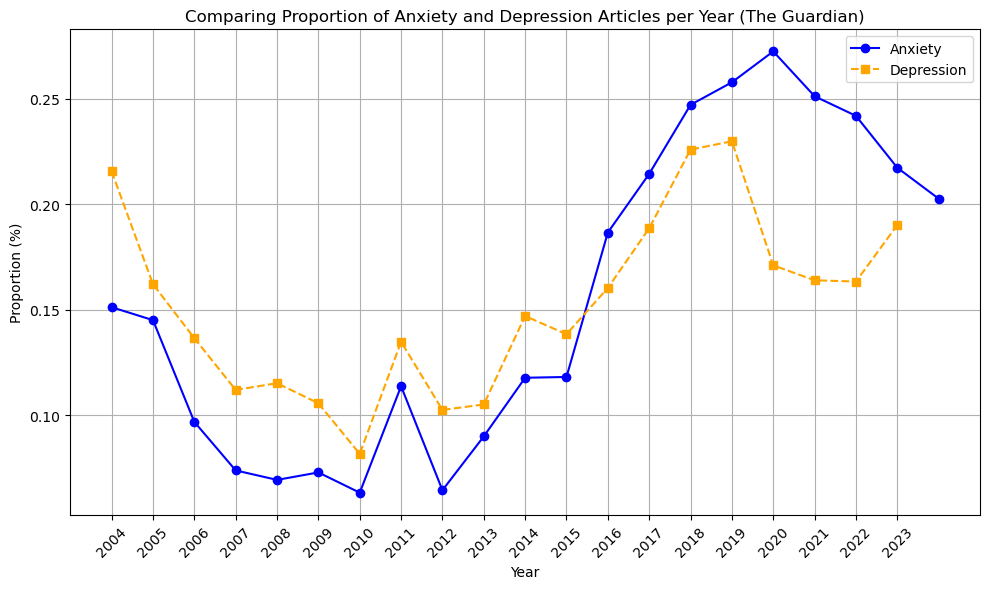

In [403]:
df_proportion_depression = df_dp[df_dp['Year'] != 2024]
percentages_a = df_proportion_anxiety['Proportion'] * 100
percentages_p = df_proportion_depression['Proportion'] * 100
plt.figure(figsize=(10, 6))

plt.plot(df_proportion_anxiety['Year'], percentages_a, marker='o', linestyle='-',
                                                   color='blue', label='Anxiety')

plt.plot(df_dp_no2024['Year'], percentages_p, marker='s', linestyle='--',
                                           color='orange', label='Depression')

 #chatgpt helped with plotting the default setting
plt.title('Comparing Proportion of Anxiety and Depression Articles per Year (The Guardian)')
plt.xlabel('Year')
plt.ylabel('Proportion (%)')
plt.legend()
plt.grid(True)
plt.xticks(range(2004, 2024), rotation=45)
plt.tight_layout()
plt.show()

Hooray! We can actually see an significant increase that reached a peak during 2020, when the pandemic hits the hardest.


Compare the frequency of anxiety and depression articles specifically in 2020

/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1707/4102236280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guardian['Date'] = pd.to_datetime(guardian['Year'].astype(str) + '-' + guardian['Month'].astype(str), format='%Y-%m')
/var/folders/5q/yq3hk8g1793ckqmn2n3xpr6c0000gn/T/ipykernel_1707/4102236280.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_depression = combined[combined['Anxiety or Depression'].isin([1,2])][combined['Sources']==1].groupby("Year").size().reset_index(name='Total Depression Articles')


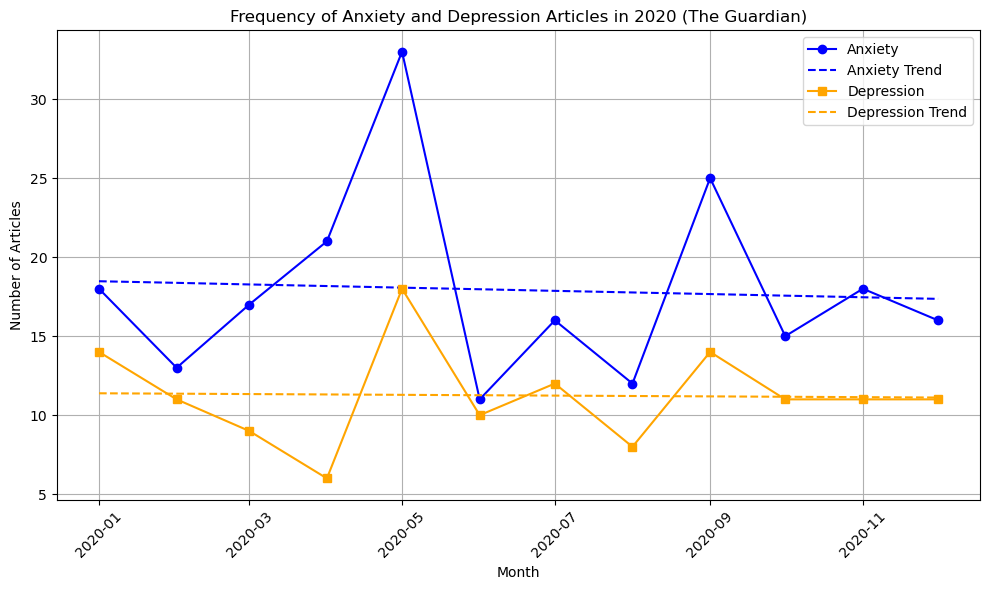

In [404]:
guardian = combined[combined['Sources']==1]
guardian['Date'] = pd.to_datetime(guardian['Year'].astype(str) + '-' + guardian['Month'].astype(str), format='%Y-%m')

#Select only 2020
filtered_df = guardian[(guardian['Date'] >= '2020-01-01') & (guardian['Date'] <= '2020-12-31')]

df_proportion_anxiety = df_proportion_anxiety[df_proportion_anxiety['Year'] != 2024]
df_depression = combined[combined['Anxiety or Depression'].isin([1,2])][combined['Sources']==1].groupby("Year").size().reset_index(name='Total Depression Articles')

filtered_df = filtered_df[filtered_df['Year'] != 2024]
anxiety_counts = filtered_df[filtered_df['Anxiety or Depression'].isin([0,2])].groupby('Date').size()


depression_counts = filtered_df[filtered_df['Anxiety or Depression'].isin([1,2])].groupby('Date').size()

# Calculate trend lines helped by chatgpt
slope_a, intercept_a, _, _, _ = stats.linregress(range(len(anxiety_counts)), 
                                                               anxiety_counts)
trend_anxiety = [slope_a * i + intercept_a for i in range(len(anxiety_counts))]

slope_d, intercept_d, _, _, _ = stats.linregress(range(len(depression_counts)), 
                                                            depression_counts)
trend_depression = [slope_d * i + intercept_d for i in range(len(depression_counts))]


plt.figure(figsize=(10, 6))
#anxiety
plt.plot(anxiety_counts.index, anxiety_counts, marker='o', color='blue', 
                                                         label='Anxiety')
plt.plot(anxiety_counts.index, trend_anxiety, linestyle='--', color='blue', 
                                                       label='Anxiety Trend')
#depression
plt.plot(depression_counts.index, depression_counts, marker='s', color='orange',
                                                           label='Depression')
plt.plot(depression_counts.index, trend_depression, linestyle='--', color='orange', 
                                                        label='Depression Trend')

plt.title('Frequency of Anxiety and Depression Articles in 2020 (The Guardian)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend()


plt.grid(True)

plt.tight_layout()
plt.show()


Findings: we can see a significant increase in May.


Now, we'll do the same analysis for The New York Times

In [ ]:
with open('all_articles_counts/yearly_n_all_nyt', 'r') as file:
    all_published_num = json.load(file)

with open('cleaned_articles/clean_nyt', 'r') as file:
    anxiety_depression_count = {}

    for line in file:
        year = line.split(',')[3].strip()
        if year in anxiety_depression_count:
            anxiety_depression_count[year] += 1
        else:
            anxiety_depression_count[year] = 1

proportion_per_year = {} #empty dictionary for proprotion each year
for year in all_published_num:
    if year in anxiety_depression_count:
        proportion_per_year[year] = ((anxiety_depression_count[year] /
                                         all_published_num[year]) * 100)
    else:
        proportion_per_year[year] = 0

First we'll do a plot of all anxiety and depression articles combined

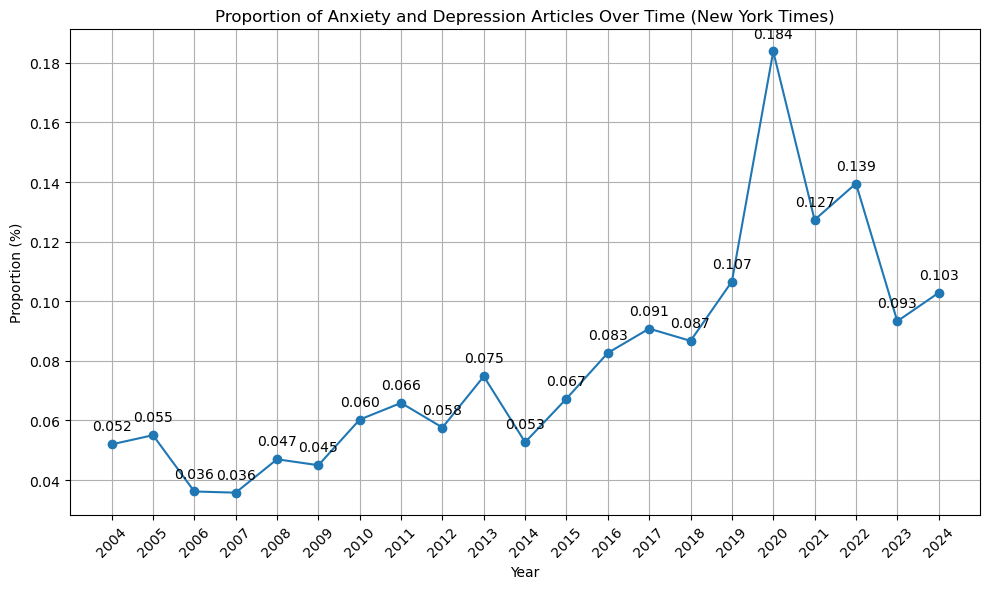

In [405]:
years = list(proportion_per_year.keys())
proportions = list(proportion_per_year.values())
 #chatgpt helped with plotting the default setting
plt.figure(figsize=(10, 6))
plt.plot(years, proportions, marker='o')
plt.title('Proportion of Anxiety and Depression Articles Over Time (New York Times)')
plt.xlabel('Year')
plt.ylabel('Proportion (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

for i, txt in enumerate(proportions):
    plt.annotate(f"{txt:.3f}", (years[i], proportions[i]),
                   textcoords="offset points", xytext=(0,10), ha='center')
#changed to 3 because the plot won't fit that much
plt.show()

* There is a noticeable increase in the proportion of articles related to anxiety and depression compared to all published articles over the years. This suggests a growing awareness and interest in mental health topics in the media.

*  While there is an overall increasing trend, there is variability in the proportions from year to year. For example, there are slight fluctuations in the proportions from 2004 to 2007, followed by a relatively steady increase from 2008 to 2019. However, there are fluctuations again in 2020 and 2021, with a slight decrease in 2023 and 2024.

* Significant Increase in Recent Years: Particularly noteworthy is the sharp increase in proportions in the most recent years, especially in 2020 where the proportion more than doubled compared to the previous year. This could be attributed to various factors such as increased societal awareness, and most importantly, Covid-19 pandemic, since we can see a large increase during the year of 2020

Count yearly for anxiety and depression articles separately

In [ ]:
with open('all_articles_counts/yearly_n_all_nyt', 'r') as file:
    all_published_num = json.load(file)

anxiety_count = {}
depression_count = {}

with open('cleaned_articles/clean_nyt', 'r') as file:
    next(file)  # Skip the header row
    for line in file:
        year, anxiety_or_depression = line.split(',')[3:5]
        year = year.strip()
        anxiety_or_depression = int(anxiety_or_depression.strip())
        if anxiety_or_depression == 0: #anxiety
            if year in anxiety_count:
                anxiety_count[year] += 1
            else:
                anxiety_count[year] = 1
        else:
            if year in depression_count:
                depression_count[year] += 1
            else:
                depression_count[year] = 1
print ("depression_count:" ,depression_count)
print ("anxiety_count:" ,anxiety_count)

After we have the count for each year, we now calculate proportion of anxiety and depression throughout 2004-2024.

In [ ]:
# Calculate proportion of anxiety and depression articles for each year
ny_anxiety_proportion = {}
ny_depression_proportion = {}

for year in anxiety_count:
    total_published = all_published_num.get(year, 0)
    ny_anxiety_proportion[year] = (anxiety_count[year] / total_published) * 100

for year in depression_count:
    total_published = all_published_num.get(year, 0)
    ny_depression_proportion[year] = (depression_count[year] / total_published) * 100

del ny_anxiety_proportion["2024"]
del ny_depression_proportion["2024"]


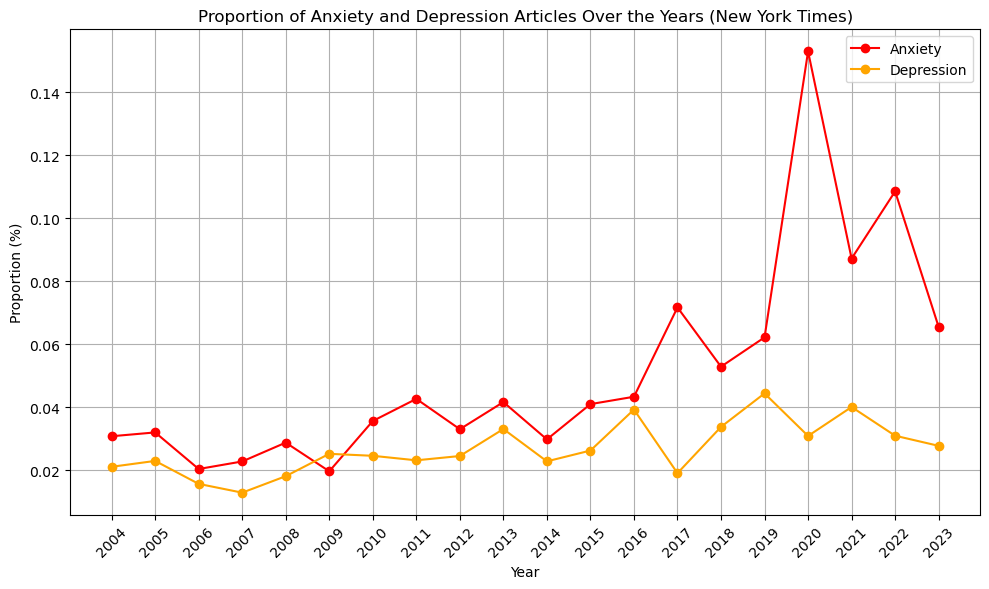

In [406]:
# Plot proportions
plt.figure(figsize=(10, 6))
plt.plot(ny_anxiety_proportion.keys(), ny_anxiety_proportion.values(), 
                                  label='Anxiety', color='red', marker='o')
plt.plot(ny_depression_proportion.keys(), ny_depression_proportion.values(), 
                            label='Depression', color='orange', marker='o')

plt.xlabel('Year')
plt.ylabel('Proportion (%)')
plt.title('Proportion of Anxiety and Depression Articles Over the Years (New York Times)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Count monthly and can compare frequency of each topic in 2020

In [ ]:
anxiety_month_count = {}
depression_month_count = {}

# Count articles related to anxiety and depression per year and month
with open('cleaned_articles/clean_nyt', 'r') as file:
    next(file)  # Skip the header row
    for line in file:
        source, month, _, year, anxiety_or_depression, *_ = line.split(',')
        year = year.strip()
        month = month.strip().zfill(2)  # Zero-pad the month to have two digits 
                                                #(e.g., '03' instead of '3')

        try:
            anxiety_or_depression = int(anxiety_or_depression.strip())
        except ValueError:
            continue  # Skip the line if the value cannot be converted to an int

        if anxiety_or_depression == 0:
            if year in anxiety_month_count:
                if month in anxiety_month_count[year]:
                    anxiety_month_count[year][month] += 1
                else:
                    anxiety_month_count[year][month] = 1
            else:
                anxiety_month_count[year] = {month: 1}
        else:
            if year in depression_month_count:
                if month in depression_month_count[year]:
                    depression_month_count[year][month] += 1
                else:
                    depression_month_count[year][month] = 1
            else:
                depression_month_count[year] = {month: 1}



Line graph of frequency change in the number of anxiety-related articles and the number of depression related articles during 2020

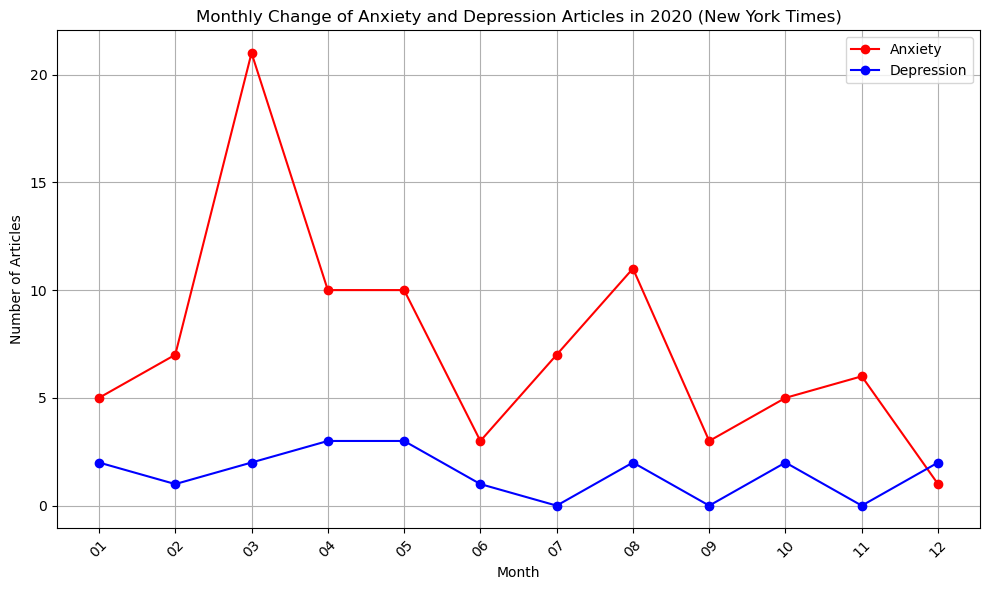

In [407]:

anxiety_2020 = anxiety_month_count.get('2020', {})
depression_2020 = depression_month_count.get('2020', {})


months = [str(i).zfill(2) for i in range(1, 13)]
depression_month_counts = [depression_2020.get(month, 0) for month in months]
anxiety_month_counts = [anxiety_2020.get(month, 0) for month in months]


plt.figure(figsize=(10, 6))
plt.plot(months, anxiety_month_counts, label='Anxiety', color='red', marker='o')
plt.plot(months, depression_month_counts, label='Depression', color='blue', marker='o')

plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.title('Monthly Change of Anxiety and Depression Articles in 2020 (New York Times)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Analysis of the above plot and possible explanation

2020 - Anxiety Articles

* There's a noticeable spike in anxiety articles in March 2020, which corresponds to the time when the COVID-19 pandemic was officially declared by the World Health Organization (WHO). This spike indicates heightened public concern and media coverage surrounding the pandemic's onset.
* Anxiety articles remain elevated throughout the year, with fluctuations in the number of articles each month. Peaks and valleys may correspond to significant events, such as lockdowns, vaccine developments, or shifts in public health policies.

2020 - Depression Articles

* Depression articles also show an increase in March 2020, although the magnitude of the increase appears smaller compared to anxiety articles. This suggests that while the pandemic contributed to heightened anxiety, it may have had a somewhat lesser impact on depression coverage during the same period.

* There are fluctuations in depression articles throughout the year, with some months showing higher counts than others. These fluctuations may reflect variations in societal responses, mental health awareness campaigns, or economic indicators.



### Look at the number of articles published on 2020 that talk specifically about covid-19 (JAYDA)

In [ ]:
nyt_covid = df_nyt_during_covid[df_nyt_during_covid['Title'].str.contains("covid|pandemic|coronavirus|covid-19|virus|lockdown")]
guardian_covid = df_g_during_covid[df_g_during_covid['Title'].str.contains("covid|pandemic|coronavirus|covid-19|virus|lockdown")]


In [ ]:
#Take count of articles published during different months in 2020
grouped_month_count_2020_g = guardian_covid[guardian_covid["Year"] == 2020].groupby("Month").size()
grouped_month_count_2020_nyt = nyt_covid[nyt_covid["Year"] == 2020].groupby("Month").size()

In [ ]:
def counts_df(series):
  """
  Takes series of counts for months, adds missing months
  and sets count for missing months to 0

  Input:
    - Series
  Output:
    - Pandas DataFrame
  """
  # create dictionary mapping months and counts from series
  counts_months_covid_nyt = {}
  for month, count in series.items():
    counts_months_covid_nyt[int(month)] = count
  for i in range(1,13):
    if i not in counts_months_covid_nyt.keys(): # adding missing months
      counts_months_covid_nyt[i] = 0 # making count for missing months 0

  # create pd df from dictionary
  counts_df = pd.DataFrame()
  counts_df["Month"] = [i for i in counts_months_covid_nyt.keys()]
  counts_df["Count"] = [i for i in counts_months_covid_nyt.values()]

  # reorder months chronologically
  counts_df = counts_df.sort_values(by='Month')
  return counts_df

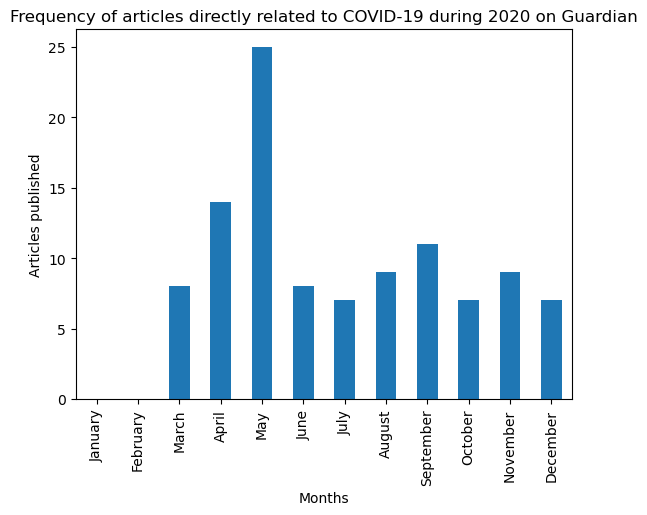

In [408]:
counts_df(grouped_month_count_2020_g)["Count"].plot(kind='bar', 
    title='Frequency of articles directly related to COVID-19 during 2020 on Guardian')
plt.xlabel('Months')
plt.ylabel('Articles published')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], ["January", "February", "March", "April",
                                            "May", "June",
                                           "July", "August", "September",
                                           "October", "November", "December"])
plt.show()

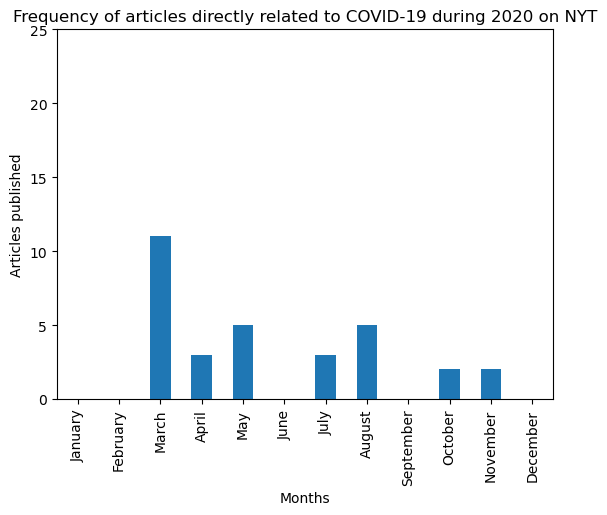

In [409]:

counts_df(grouped_month_count_2020_nyt)["Count"].plot(kind='bar', 
    title='Frequency of articles directly related to COVID-19 during 2020 on NYT')
plt.xlabel('Months')
plt.ylabel('Articles published')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11], ["January", "February", "March", "April",
                                            "May", "June",
                                           "July", "August", "September",
                                           "October", "November", "December"])
plt.ylim(0, 25)
plt.show()

Surprisingly, not many articles were strictly related to covid-19 even if we did see a peak in 2020.
Increase of mental health discussion could be also influenced by other factors such as different generations, normal social evolution, etc.

### Most used words in titles in different time frames (pre, during, post) (NATASHA)

In [ ]:
def tokenize_words(title):
    '''
    Tokenizes titles into list of words

    Inputs:
      - title (str): article's title

    Outputs:
      (list): list of relevant words contained in the title
    '''

    #I asked ChatGPT: "create me a good stop words list including pronouns,
    #auxiliary verbs, etc"
    stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
    'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she',
    'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
    'these', 'those', 'am', 'is', 'are',  'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
    'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of',
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through',
    'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
    'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both',
    'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
    'just', 'don', 'should', 'now']

    words_list = []

    words = title.split()

    for word in words:
        if len(word) == 0:
            continue

        if word in stop_words:
            continue

        words_list.append(word)

    return words_list


def count_words(data):
    '''
    Create a dictionary that maps words with their frequency on all articles'
    titles

    Inputs:
      - data (series): articles' titles

    Outputs:
      - (dict): dictionary mapping words with their frequencies

    '''

    title_words_counts = {}

    for entry in data:
        row_words = tokenize_words(entry)

        for word in row_words:
            title_words_counts[word] = title_words_counts.get(word, 0) + 1

    #I asked ChatGPT how to sort by value

    sorted_dict= dict(sorted(title_words_counts.items(), key=lambda item: item[1],
                                                                  reverse=True))
    return sorted_dict

In [ ]:
#Apply function to count words on titles

#NYT titles on different time frames
dict_nyt_pre_covid = count_words(df_nyt_pre_covid["Title"])
dict_nyt_during_covid = count_words(df_nyt_during_covid["Title"])
dict_nyt_post_covid = count_words(df_nyt_post_covid["Title"])

#Guardian titles on different time frames
dict_g_pre_covid = count_words(df_g_pre_covid["Title"])
dict_g_during_covid = count_words(df_g_during_covid["Title"])
dict_g_post_covid = count_words(df_g_post_covid["Title"])


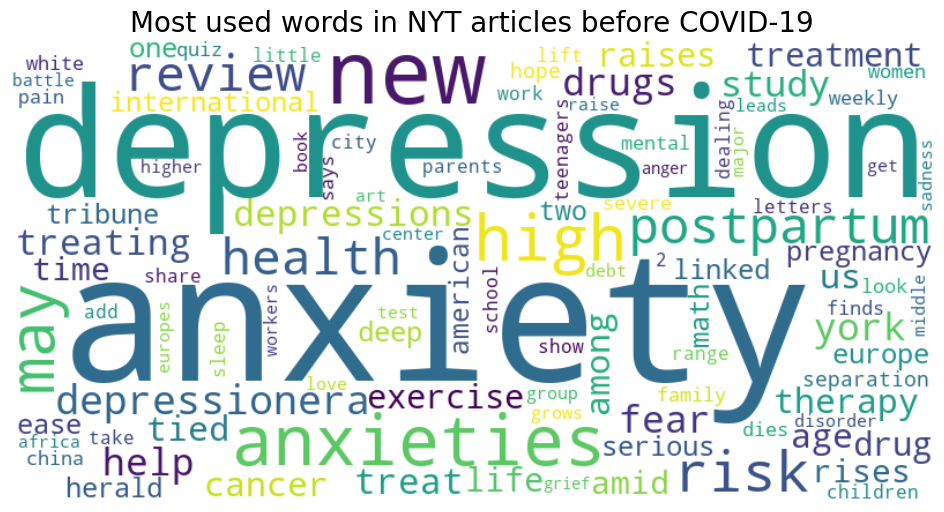

In [410]:
#I asked ChatGPT: "how can I do a word cloud from a dictionary with words and
#their counts?" and it showed me how to use this wordcloud object

# Create a WordCloud object with customized parameters
wordcloud = WordCloud(width=800, height=400, background_color='white',
                                                  colormap='viridis',
                      max_words=100, contour_color='steelblue', contour_width=2)

#NEW YORK TIMES

wordcloud.generate_from_frequencies(dict_nyt_pre_covid)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most used words in NYT articles before COVID-19', fontsize=20)
plt.axis('off')
plt.show()

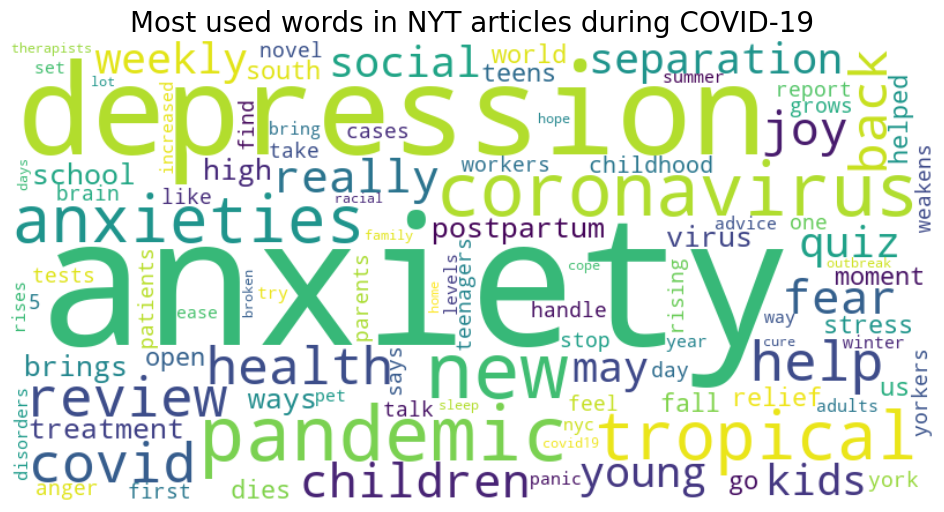

In [411]:
wordcloud.generate_from_frequencies(dict_nyt_during_covid)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most used words in NYT articles during COVID-19', fontsize=20)
plt.axis('off')
plt.show()

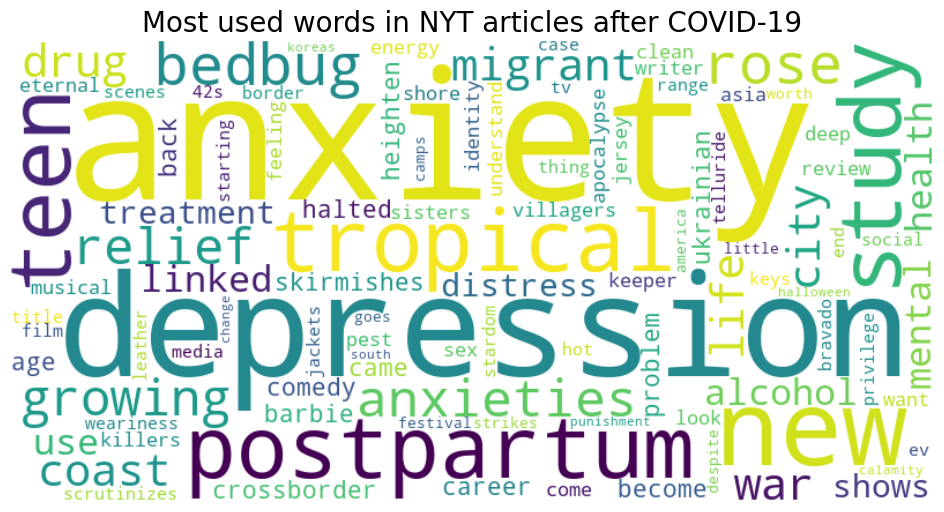

In [412]:
wordcloud.generate_from_frequencies(dict_nyt_post_covid)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most used words in NYT articles after COVID-19', fontsize=20)
plt.axis('off')
plt.show()

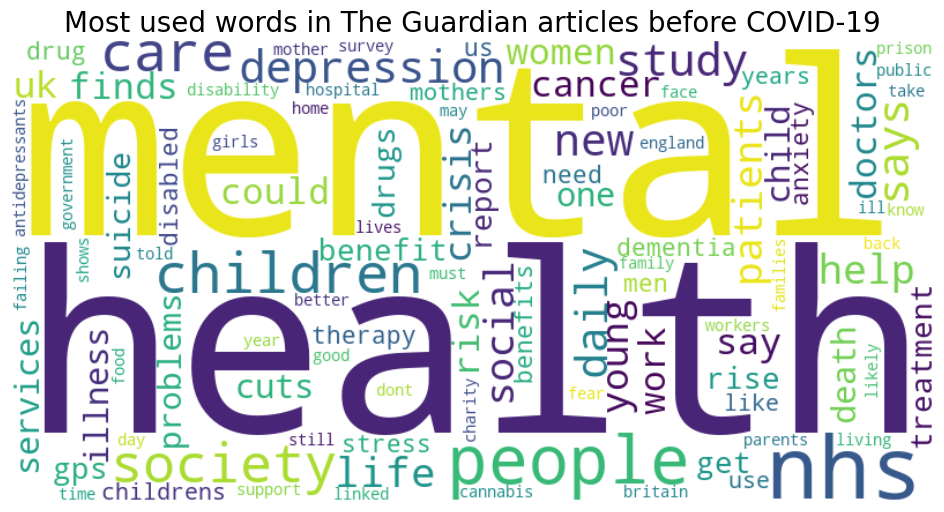

In [413]:
#THE GUARDIAN
wordcloud.generate_from_frequencies(dict_g_pre_covid)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most used words in The Guardian articles before COVID-19', fontsize=20)
plt.axis('off')
plt.show()

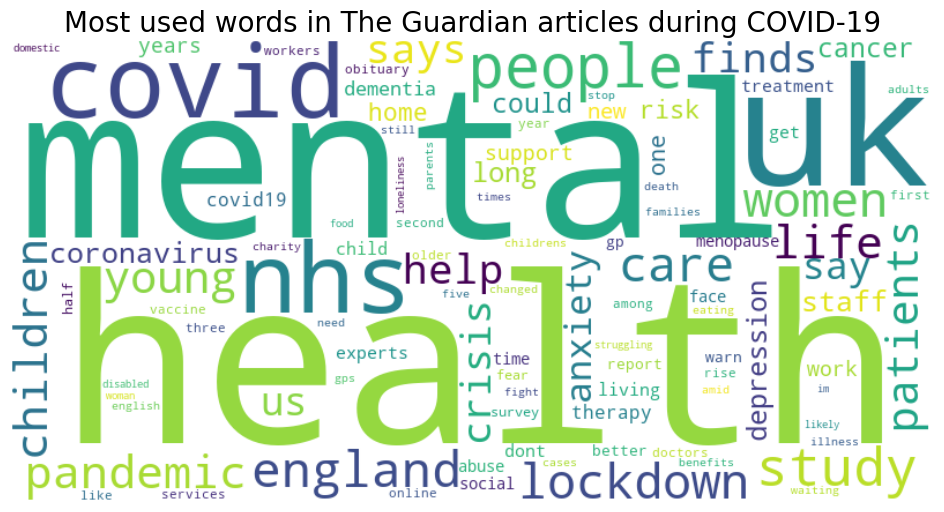

In [414]:
wordcloud.generate_from_frequencies(dict_g_during_covid)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most used words in The Guardian articles during COVID-19',
                                                         fontsize=20)
plt.axis('off')
plt.show()

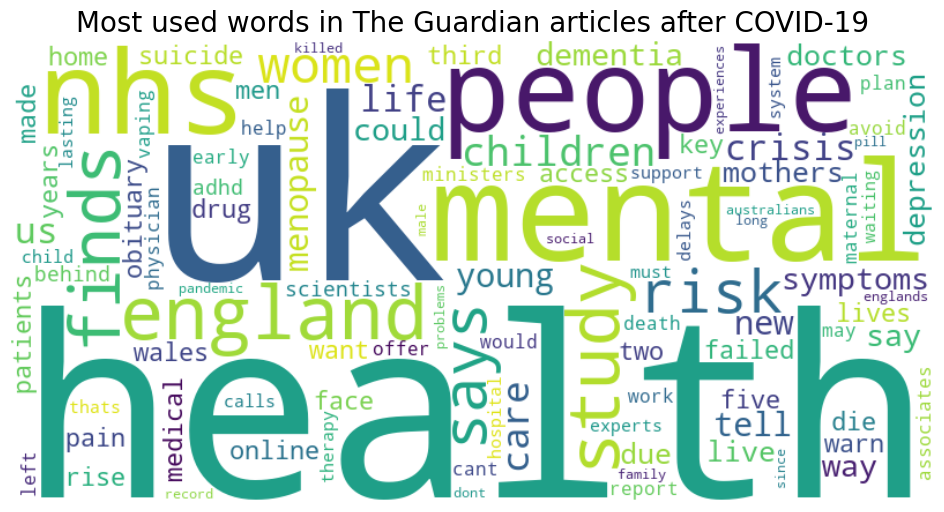

In [415]:
wordcloud.generate_from_frequencies(dict_g_post_covid)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most used words in The Guardian articles after COVID-19', fontsize=20)
plt.axis('off')
plt.show()

### Most used n-grams for body texts/abstracts (KEXIN)

Check most used n-grams in The Guardian's body texts and The NYT's abstracts.

For this part, we'll look at both newspapers together. The reason for this is that NYT's API only provided abstracts for each article but not the complete body text. Abstracts are short and therefore, we did not see many n-grams in the NYT itself.

In [ ]:
#Rename column of "Abstract" in NYT dataframe to "Body Text" so we can match
#NYT's abstract and Guardian's body text under the same column for combined
#analysis

nyt_renamed = clean_nyt.rename(columns={'Abstract': 'Body Text'})

#Create new combined dataframe with the renamed NYT dataframe
combined = pd.concat([clean_guardian, nyt_renamed], axis=0, ignore_index=True)

In [ ]:
#Select societyguardian as a stop word because it appeared as just one word
#that was creating strange n-grams and it was probably an
#hyperlink in the original article or so.

#Also delete "mental" and "health" to avoid getting obvious n-grams
custom_stop_words = ["societyguardian", "mental", "health"]
combined_stop_words = list(ENGLISH_STOP_WORDS.union(custom_stop_words))
vectorizer = CountVectorizer(stop_words=combined_stop_words)

#Function to find n-grams
def find_most_common_ngrams(df, column_name, anxiety_or_depression, time_frame,
                                                              n=3, top_n=5):
    """
    Finds the most common n-grams across all n values from 1 to max_n in the
    specified column of a pandas DataFrame.

    Inputs:
      - df: Pandas DataFrame containing the data.
      - column_name: Name of the column to analyze.
      - anxiety_or_depression: Value to filter by in the "Anxiety or Depression" column (lst [0,1] or [1,2]).
      - n: The number of words in the n-gram.
      - top_n: The number of most common n-grams to return.

    Outputs:
      - A list of tuples with the most common n-grams and their counts.
    """
    # Filter by the value in the "Anxiety or Depression" column and the "Time Frame" column
    filtered_df = df[(df['Anxiety or Depression'].isin(anxiety_or_depression)) & 
                                               (df['Time frame'] == time_frame)]

    # Concatenate the text from the specified column
    text_data = filtered_df[column_name].dropna().tolist()

    # Find the most common n-grams for each n value
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words=combined_stop_words)
    X = vectorizer.fit_transform(text_data)

    # Sum up the counts of each n-gram and return the most common ones
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    return words_freq[:top_n]

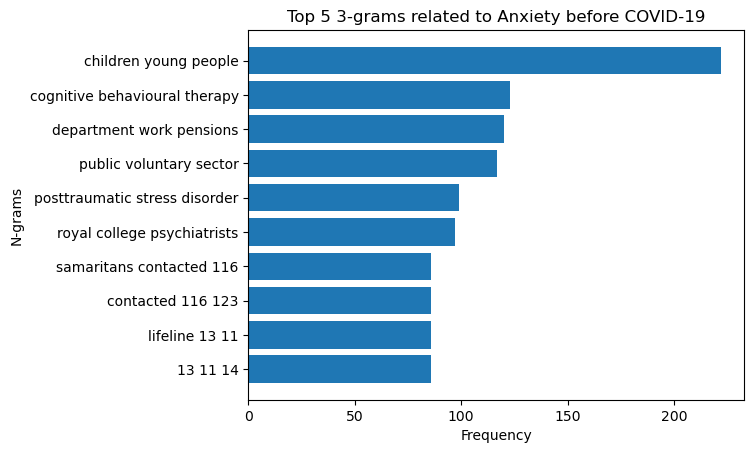

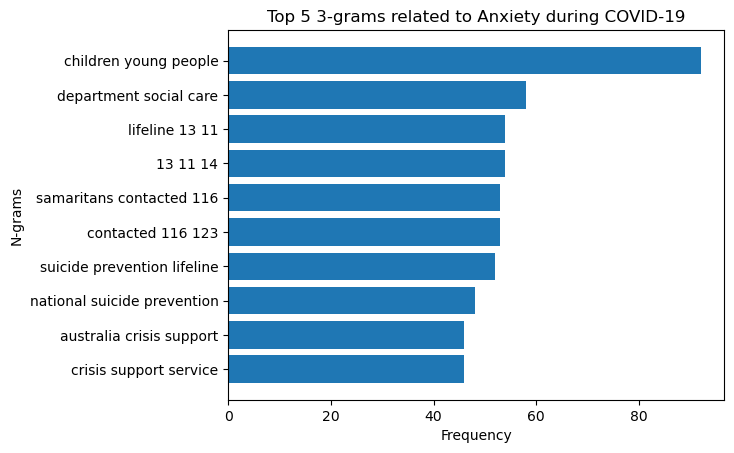

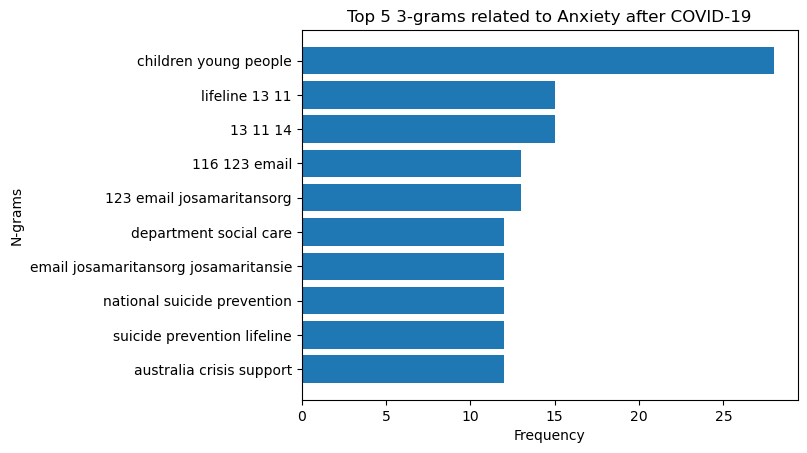

In [416]:
# find most used n-grams with anxiety and visualization
# Pre COVID-19
ngrams_freq_anxiety_pre = find_most_common_ngrams(combined, 'Body Text', 
                                                   [0,2], 0, n=3, top_n=10)
ngrams, frequencies = zip(*ngrams_freq_anxiety_pre)
plt.barh(ngrams, frequencies)
plt.xlabel('Frequency')
plt.ylabel('N-grams')
plt.title('Top 5 3-grams related to Anxiety before COVID-19')
plt.gca().invert_yaxis() # Invert the y-axis to have the highest frequency at the top
plt.show()

# During COVID-19
ngrams_freq_anxiety_during = find_most_common_ngrams(combined, 'Body Text', [0,2], 1, n=3, top_n=10)
ngrams, frequencies = zip(*ngrams_freq_anxiety_during)
plt.barh(ngrams, frequencies)
plt.xlabel('Frequency')
plt.ylabel('N-grams')
plt.title('Top 5 3-grams related to Anxiety during COVID-19')
plt.gca().invert_yaxis()
plt.show()

# Post COVID-19
ngrams_freq_anxiety_post = find_most_common_ngrams(combined, 'Body Text', [0,2], 2, n=3, top_n=10)
ngrams, frequencies = zip(*ngrams_freq_anxiety_post)
plt.barh(ngrams, frequencies)
plt.xlabel('Frequency')
plt.ylabel('N-grams')
plt.title('Top 5 3-grams related to Anxiety after COVID-19')
plt.gca().invert_yaxis()
plt.show()

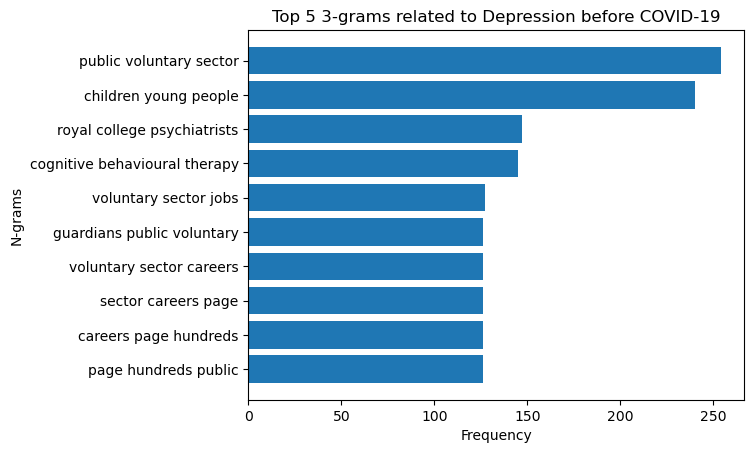

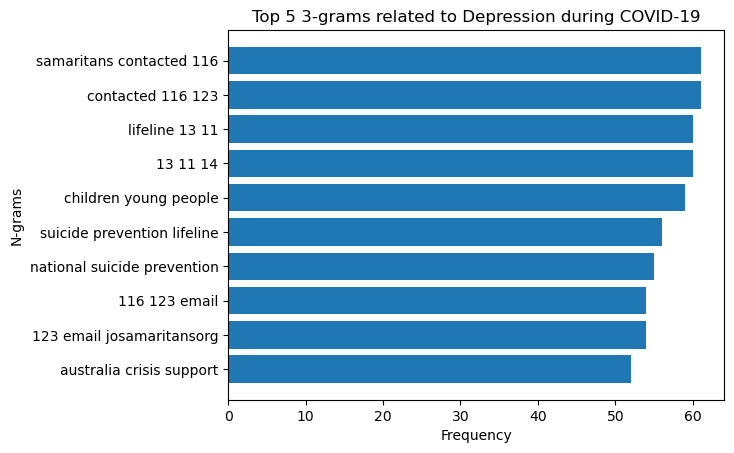

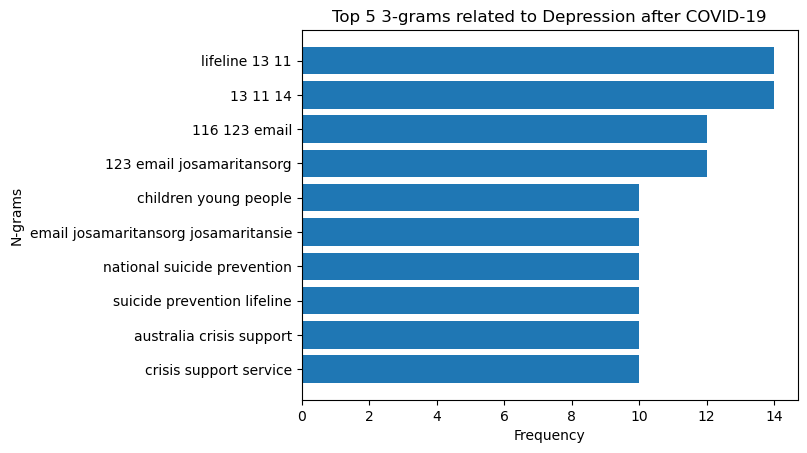

In [417]:
# find most used n-grams with depression and visualization
# Pre COVID-19
ngrams_freq_depression_pre = find_most_common_ngrams(combined, 'Body Text',
                                                     [1,2], 0, n=3, top_n=10)
ngrams, frequencies = zip(*ngrams_freq_depression_pre)
plt.barh(ngrams, frequencies)
plt.xlabel('Frequency')
plt.ylabel('N-grams')
plt.title('Top 5 3-grams related to Depression before COVID-19')
plt.gca().invert_yaxis()
plt.show()

# During COVID-19
ngrams_freq_depression_during = find_most_common_ngrams(combined, 'Body Text',
                                                     [1,2], 1, n=3, top_n=10)
ngrams, frequencies = zip(*ngrams_freq_depression_during)
plt.barh(ngrams, frequencies)
plt.xlabel('Frequency')
plt.ylabel('N-grams')
plt.title('Top 5 3-grams related to Depression during COVID-19')
plt.gca().invert_yaxis()
plt.show()

# Post COVID-19
ngrams_freq_depression_post = find_most_common_ngrams(combined, 'Body Text',
                                                     [1,2], 2, n=3, top_n=10)
ngrams, frequencies = zip(*ngrams_freq_depression_post)
plt.barh(ngrams, frequencies)
plt.xlabel('Frequency')
plt.ylabel('N-grams')
plt.title('Top 5 3-grams related to Depression after COVID-19')
plt.gca().invert_yaxis()
plt.show()

### Sentiment Analysis for titles (JAYDA)

We'll be using first the AFINN Sentiment Lexicon

#### AFINN Sentiment Lexicon: 
A list of English words rated for valence by Finn Årup Nielsen from negative to positive, on a scale from -5 to 5  

In [ ]:
afinn = Afinn()

# add afinn score to df
combined['afinn score'] = [afinn.score(i) for i in combined['Title']]
combined.head()

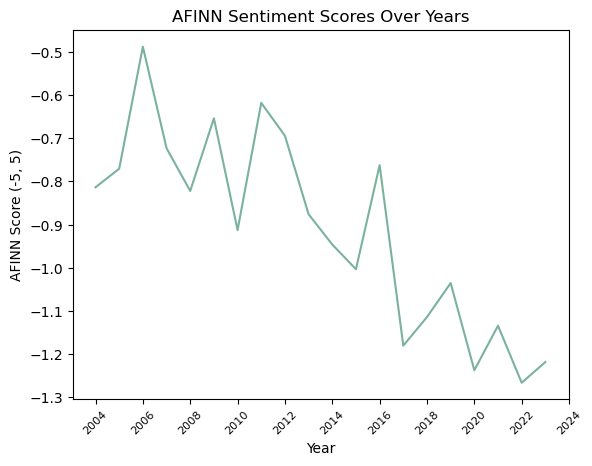

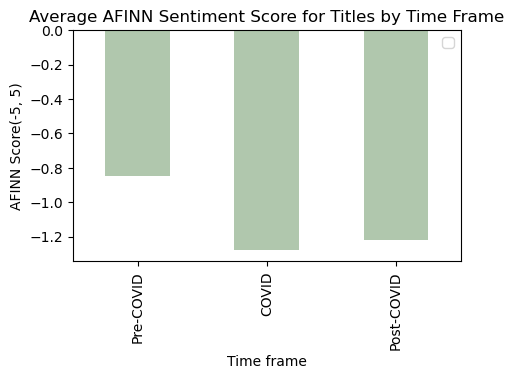

In [418]:
# afinn scores over years
combined[combined['Year']!= 2024].groupby("Year")['afinn score'].mean(numeric_only=True).plot(color='#7AB29C')

plt.title('AFINN Sentiment Scores Over Years')
plt.ylabel('AFINN Score (-5, 5)')
plt.xlabel('Year')
plt.xticks(range(2004, 2025, 2), rotation=45, fontsize=8)

# affin sentiment scores by time frame
combined.groupby("Time frame").mean(numeric_only=True).plot(y="afinn score",
                             kind = "bar", color='#B0C7AD', figsize = (5,3))

plt.title("Average AFINN Sentiment Score for Titles by Time Frame")
plt.xticks([0,1, 2], ["Pre-COVID", "COVID", "Post-COVID"])
plt.ylabel("AFINN Score(-5, 5)")
plt.legend([])

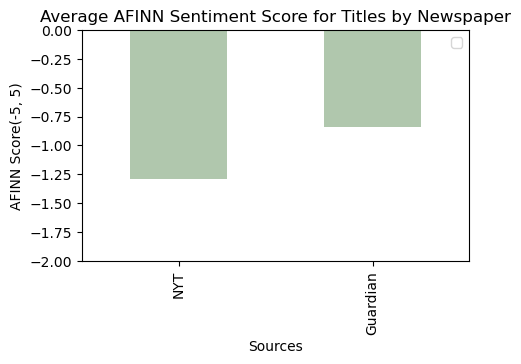

In [419]:
# afinn scores by source
combined.groupby("Sources").mean(numeric_only=True).plot(y="afinn score",
                                 kind = "bar", color='#B0C7AD', figsize = (5,3))
plt.ylim(-2,0)

plt.title("Average AFINN Sentiment Score for Titles by Newspaper")
plt.xticks([0,1], ["NYT", "Guardian"])
plt.ylabel("AFINN Score(-5, 5)")
plt.legend([])

Now, we'll try another approach for sentiment analysis

#### NRC Emotion Lexicon:
A list of English words and  associations with eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and the sentiments (negative and positive), rated wither 1 or 0. This data source was created by crowd-sourcing through Mechanical Turk

In [ ]:
# import ncr sentiment file
ncr = pd.read_csv('NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')

# reformat csv
ncr['word'] = ncr["aback\tanger\t0"].str.split('\t')

# create dictionary of sentiment words
sentiments = {}
for words in ncr['word']:
    word = words[0]
    sentiment = words[1]
    score = words[2]

    if sentiment not in sentiments.keys():
        sentiments[sentiment] = []

    if score == '1':
        sentiments[sentiment].append(word)


# create function to create dictionary of sentiment scores based on text
def sentiment_score(text):
    '''
    Takes text and creates a dictionary of the sentiment scores
    for the different emotions and sentiments in the NCR Emotion Lexicon

    Input:
      - string

    Output:
      - dictionary mapping sentiment to number of words in string in the
       dictionary for that sentiment
    '''
    scores = {}
    for key in sentiments.keys():
        scores[key] = 0

    for word in text.split():
        for sentiment in sentiments.items():
            if word in sentiment[1]:
                scores[sentiment[0]] += 1

    return scores


# create dictionaries for each column
combined['sentiment scores'] = combined['Title'].apply(sentiment_score)

# create columns for different sentiment scores based on dictionaries
for sentiment in sentiments.keys():
    combined[sentiment] = [i[sentiment] for i in combined['sentiment scores']]

# create column of length of strings to find proportions
combined["len"] = [len(i.split()) for i in combined["Title"]]

# find proportions of different sentiments
for sentiment in sentiments.keys():
    combined[sentiment + "_prop"] = combined[sentiment]/ combined['len']

# save to csv
combined[['Sources', 'Month', 'Date', 'Year', 'Anxiety or Depression','Title', \
          'Body Text', 'Time frame', 'afinn score', 'anticipation_prop','disgust_prop',\
         'fear_prop', 'joy_prop', 'negative_prop','positive_prop', 'sadness_prop', 'surprise_prop',\
              'trust_prop','anger_prop']].to_csv('sentiment_data', index = False)

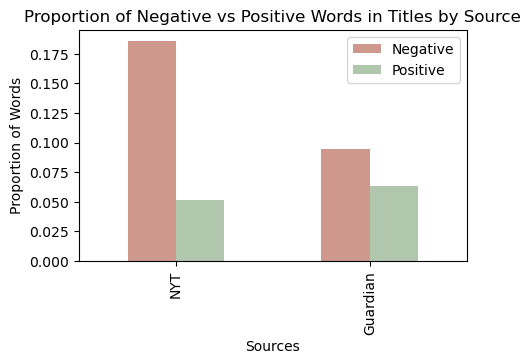

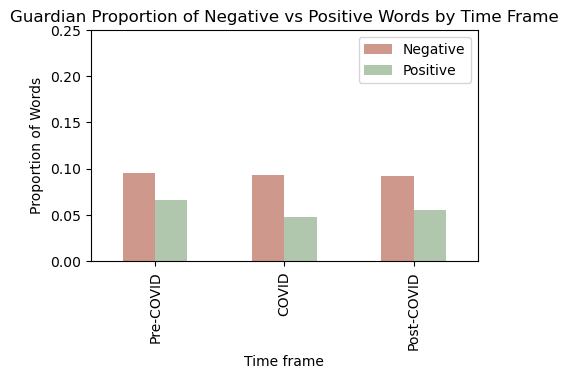

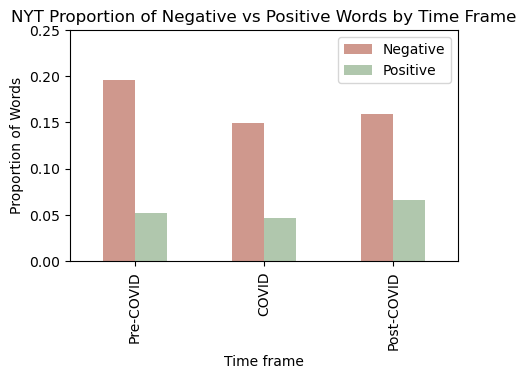

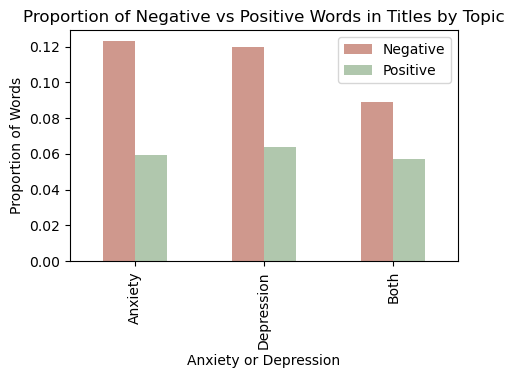

In [420]:
# ncr negative vs positve

# by source
combined.groupby("Sources").mean(numeric_only=True).plot(y=["negative_prop", 
    'positive_prop'], kind = "bar", color=['#CF988D','#B0C7AD'], figsize = (5,3))

plt.title('Proportion of Negative vs Positive Words in Titles by Source')
plt.xticks([0,1,], ["NYT", "Guardian"])
plt.ylabel("Proportion of Words")
plt.legend(['Negative', 'Positive'])

# guardian by time frame
combined[combined['Sources']==1].groupby("Time frame").mean(numeric_only=True).plot(y=["negative_prop", 
    'positive_prop'], kind = "bar", color=['#CF988D','#B0C7AD'], figsize = (5,3))

plt.ylim(0, 0.25)
plt.title('Guardian Proportion of Negative vs Positive Words by Time Frame')
plt.xticks([0,1, 2], ["Pre-COVID", "COVID", "Post-COVID"])
plt.ylabel("Proportion of Words")
plt.legend(["Negative", "Positive"])

# nyt by time frame
combined[combined['Sources']==0].groupby("Time frame").mean(numeric_only=True).plot\
    (y=["negative_prop", 'positive_prop'], kind = "bar", color=['#CF988D',
                                                    '#B0C7AD'], figsize = (5,3))

plt.ylim(0, 0.25)
plt.title('NYT Proportion of Negative vs Positive Words by Time Frame')
plt.xticks([0,1, 2], ["Pre-COVID", "COVID", "Post-COVID"])
plt.ylabel("Proportion of Words")
plt.legend(["Negative", "Positive"])

# by topic
combined.groupby("Anxiety or Depression").mean(numeric_only=True).plot\
    (y=["negative_prop", 'positive_prop'], kind = "bar", color=['#CF988D',
                                                    '#B0C7AD'], figsize = (5,3))

plt.title('Proportion of Negative vs Positive Words in Titles by Topic')
plt.xticks([0,1,2], ["Anxiety", "Depression", 'Both'])
plt.ylabel("Proportion of Words")
plt.legend(['Negative', 'Positive'])

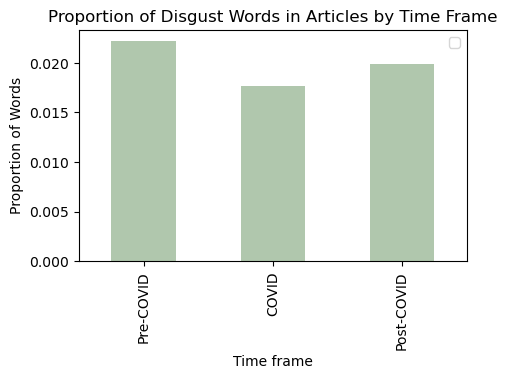

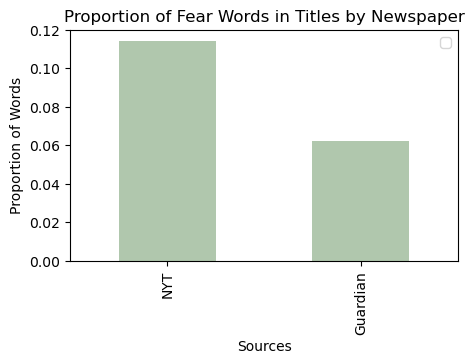

In [421]:
# emotional words

# disgust by time frame
combined.groupby("Time frame").mean(numeric_only=True).plot(y= "disgust_prop",
                                 kind = "bar", color='#B0C7AD', figsize = (5,3))

plt.title('Proportion of Disgust Words in Articles by Time Frame')
plt.xticks([0,1, 2], ["Pre-COVID", "COVID", "Post-COVID"])
plt.ylabel("Proportion of Words")
plt.legend([])

# fear by source
combined.groupby("Sources").mean(numeric_only=True).plot(y= "fear_prop", 
                                 kind = "bar", color='#B0C7AD', figsize = (5,3))

plt.title('Proportion of Fear Words in Titles by Newspaper')
plt.xticks([0,1], ["NYT", "Guardian"])
plt.ylabel("Proportion of Words")
plt.legend([])

(0.0, 0.22)

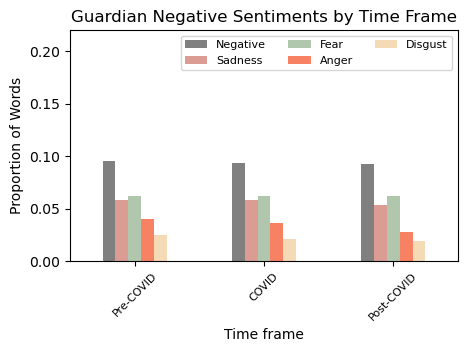

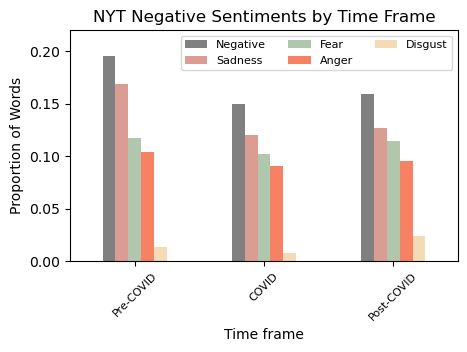

In [422]:
# negative emotions

# guardian
combined[combined['Sources']==1].groupby("Time frame").mean(numeric_only=True).plot\
    (y=['negative_prop','sadness_prop', 'fear_prop', 'anger_prop','disgust_prop'], kind = "bar", \
     color=['grey', '#db9c94','#b0c7ad',"#f78263", '#f4dbb5'], figsize = (5,3))
plt.legend(['Negative', 'Sadness', 'Fear', 'Anger', 'Disgust'], loc='upper right', 
                                                            fontsize=8, ncol=3)
# ask chatgbt how to change location and number of columns for legend

plt.title('Guardian Negative Sentiments by Time Frame')
plt.xticks([0,1,2], ["Pre-COVID", "COVID", "Post-COVID"], rotation=45, fontsize=8)
plt.ylabel("Proportion of Words")
plt.ylim(0, 0.22)

# nyt
combined[combined['Sources']==0].groupby("Time frame").mean(numeric_only=True).plot\
    (y=['negative_prop','sadness_prop', 'fear_prop', 'anger_prop','disgust_prop'], kind = "bar",
     color=['grey', '#db9c94','#b0c7ad',"#f78263", '#f4dbb5'], figsize = (5,3))
plt.legend(['Negative', 'Sadness', 'Fear', 'Anger', 'Disgust'], loc='upper right', 
                                                             fontsize=8, ncol=3)

plt.title('NYT Negative Sentiments by Time Frame')
plt.xticks([0,1,2], ["Pre-COVID", "COVID", "Post-COVID"], rotation=45, fontsize=8)
plt.ylabel("Proportion of Words")
plt.ylim(0, 0.22)

(0.0, 0.22)

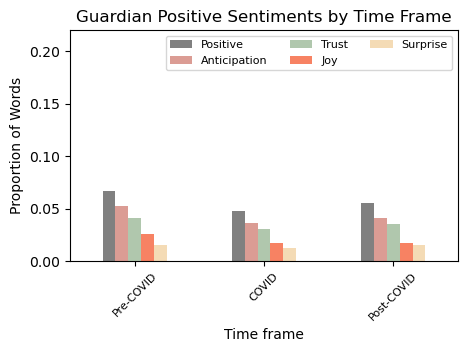

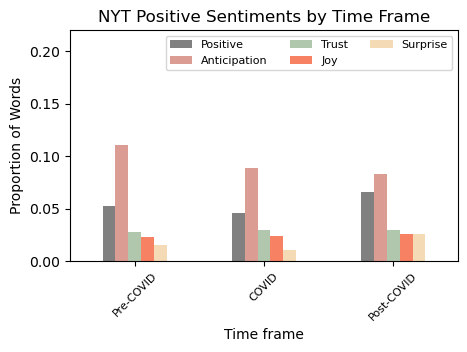

In [423]:
# positive emotions

# guardian
combined[combined['Sources']==1].groupby("Time frame").mean(numeric_only=True).plot\
    (y=['positive_prop','anticipation_prop', 'trust_prop','joy_prop', 'surprise_prop'], kind = "bar", \
     color=['grey', '#db9c94','#b0c7ad',"#f78263", '#f4dbb5'], figsize = (5,3))
plt.legend(['Positive', 'Anticipation', 'Trust', 'Joy', 'Surprise'], loc='upper right', fontsize=8, ncol=3)

plt.title('Guardian Positive Sentiments by Time Frame')
plt.xticks([0,1,2], ["Pre-COVID", "COVID", "Post-COVID"], rotation=45, fontsize=8)
plt.ylabel("Proportion of Words")
plt.ylim(0, 0.22)


# nyt
combined[combined['Sources']==0].groupby("Time frame").mean(numeric_only=True).plot\
    (y=['positive_prop','anticipation_prop', 'trust_prop','joy_prop', 'surprise_prop'], kind = "bar", \
     color=['grey', '#db9c94','#b0c7ad',"#f78263", '#f4dbb5'], figsize = (5,3))
plt.legend(['Positive', 'Anticipation', 'Trust', 'Joy', 'Surprise'], 
                                loc='upper right', fontsize=8, ncol=3)

plt.title('NYT Positive Sentiments by Time Frame')
plt.xticks([0,1,2], ["Pre-COVID", "COVID", "Post-COVID"], rotation=45, fontsize=8)
plt.ylabel("Proportion of Words")
plt.ylim(0, 0.22)


In [424]:
# create df with average negative and positive sentiments over the years by source
sentiment_avgs = pd.DataFrame(combined.groupby("Year")['positive_prop'].mean())
sentiment_avgs.rename(columns={'positive_prop': 'pos'}, inplace=True)
sentiment_avgs['neg'] = combined.groupby("Year")['negative_prop'].mean()
sentiment_avgs['neut'] = 1 - (sentiment_avgs['neg'] + sentiment_avgs['pos'])

sentiment_avgs['g_neg'] = combined[combined['Sources']==1].groupby("Year")['negative_prop'].mean()
sentiment_avgs['g_pos'] = combined[combined['Sources']==1].groupby("Year")['positive_prop'].mean()
sentiment_avgs['g_neut'] = 1 - (sentiment_avgs['g_neg'] + sentiment_avgs['g_pos'])

sentiment_avgs['nyt_pos'] = combined[combined['Sources']==0].groupby("Year")['positive_prop'].mean()
sentiment_avgs['nyt_neg'] = combined[combined['Sources']==0].groupby("Year")['negative_prop'].mean()
sentiment_avgs['nyt_neut'] = 1 - (sentiment_avgs['nyt_neg'] + sentiment_avgs['nyt_pos'])

sentiment_avgs.reset_index(inplace=True)
sentiment_avgs.head()

,Year,pos,neg,neut,g_neg,g_pos,g_neut,nyt_pos,nyt_neg,nyt_neut
0,2004,0.073812,0.129310,0.796879,0.113708,0.076312,0.809980,0.061099,0.208641,0.730260
1,2005,0.079074,0.136940,0.783986,0.118287,0.083947,0.797766,0.060816,0.206822,0.732362
2,2006,0.069563,0.130006,0.800431,0.107708,0.074210,0.818082,0.055150,0.199162,0.745688
3,2007,0.087769,0.118434,0.793797,0.093524,0.093913,0.812563,0.061364,0.225495,0.713140
4,2008,0.070667,0.127629,0.801704,0.098688,0.074558,0.826754,0.059407,0.211365,0.729228


/Users/natashacarpcast/anaconda3/envs/macs30112/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/natashacarpcast/anaconda3/envs/macs30112/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/natashacarpcast/anaconda3/envs/macs30112/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/natashacarpcast/anaconda3/envs/macs30112/lib/python3.11/site-packages/seaborn/_oldcore.py:111

([<matplotlib.axis.XTick at 0x17d11e310>,
 [Text(2004, 0, '2004'),
  Text(2006, 0, '2006'),
  Text(2008, 0, '2008'),
  Text(2010, 0, '2010'),
  Text(2012, 0, '2012'),
  Text(2014, 0, '2014'),
  Text(2016, 0, '2016'),
  Text(2018, 0, '2018'),
  Text(2020, 0, '2020'),
  Text(2022, 0, '2022'),
  Text(2024, 0, '2024')])

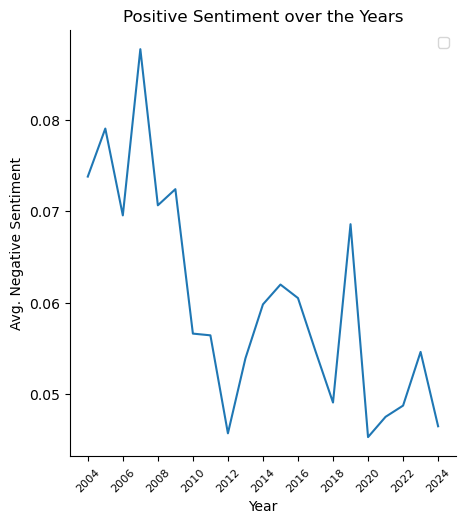

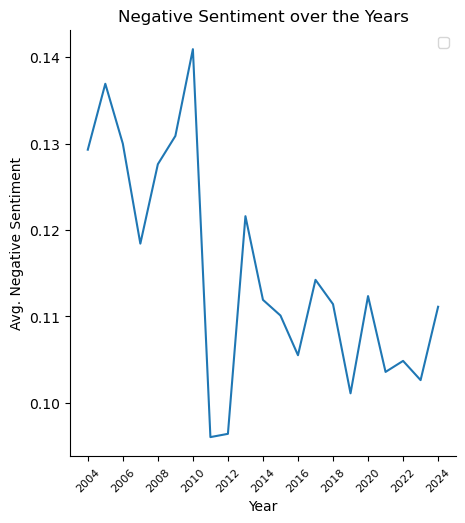

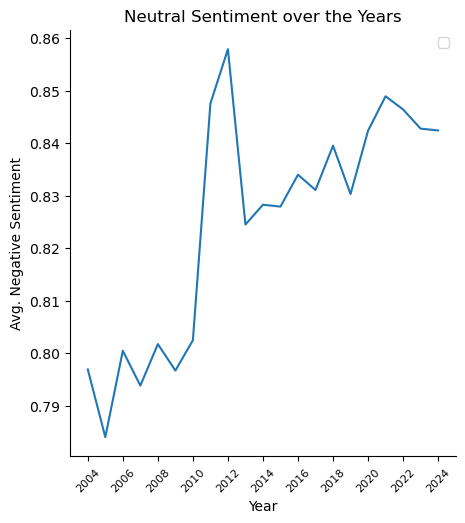

In [425]:
# sentiments over years

#positive overall
sns.relplot(data = sentiment_avgs,
            x = 'Year',
            y = 'pos',
            kind = 'line')

plt.title('Positive Sentiment over the Years')
plt.ylabel('Avg. Negative Sentiment', size = 10)
plt.xlabel('Year', size = 10)
plt.legend([]);
plt.xticks(range(2004, 2025, 2), rotation=45, fontsize=8)

# negative overall
sns.relplot(data = sentiment_avgs,
            x = 'Year',
            y = 'neg',
            kind = 'line')

plt.title('Negative Sentiment over the Years')
plt.ylabel('Avg. Negative Sentiment', size = 10)
plt.xlabel('Year', size = 10)
plt.legend([]);
plt.xticks(range(2004, 2025, 2), rotation=45, fontsize=8)

# neutral overall
sns.relplot(data = sentiment_avgs,
            x = 'Year',
            y = "neut",
            kind = 'line')

plt.title('Neutral Sentiment over the Years')
plt.ylabel('Avg. Negative Sentiment', size = 10)
plt.xlabel('Year', size = 10)
plt.legend([]);
plt.xticks(range(2004, 2025, 2), rotation=45, fontsize=8)

([<matplotlib.axis.XTick at 0x1798ed490>,
 [Text(2004, 0, '2004'),
  Text(2006, 0, '2006'),
  Text(2008, 0, '2008'),
  Text(2010, 0, '2010'),
  Text(2012, 0, '2012'),
  Text(2014, 0, '2014'),
  Text(2016, 0, '2016'),
  Text(2018, 0, '2018'),
  Text(2020, 0, '2020'),
  Text(2022, 0, '2022'),
  Text(2024, 0, '2024')])

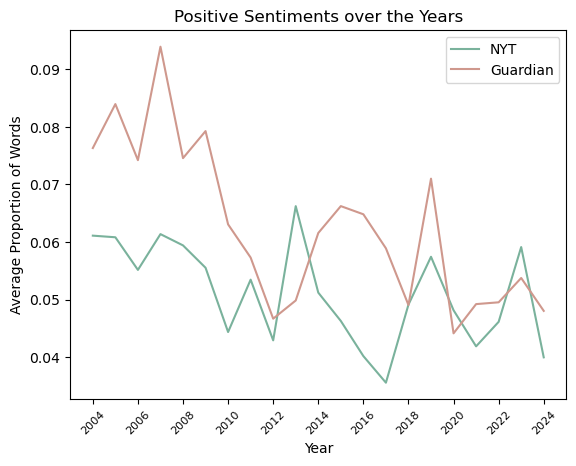

In [426]:
# positive by source
x = sentiment_avgs['Year']
y1 = sentiment_avgs['nyt_pos']
y2 = sentiment_avgs['g_pos']
plt.plot(x, y1, label='NYT', color='#7AB29C')
plt.plot(x, y2, label='Guardian', color='#cf988d')

plt.title("Positive Sentiments over the Years")
plt.xlabel('Year')
plt.ylabel('Average Proportion of Words')
plt.legend(["NYT", "Guardian"])
plt.xticks(range(2004, 2025, 2), rotation=45, fontsize=8)

([<matplotlib.axis.XTick at 0x15d324ed0>,
 [Text(2004, 0, '2004'),
  Text(2006, 0, '2006'),
  Text(2008, 0, '2008'),
  Text(2010, 0, '2010'),
  Text(2012, 0, '2012'),
  Text(2014, 0, '2014'),
  Text(2016, 0, '2016'),
  Text(2018, 0, '2018'),
  Text(2020, 0, '2020'),
  Text(2022, 0, '2022'),
  Text(2024, 0, '2024')])

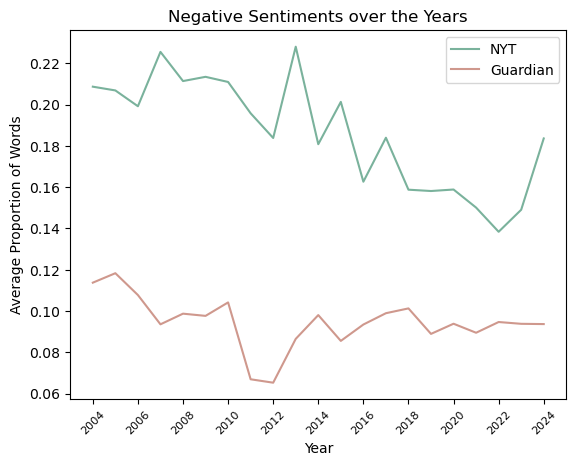

In [427]:
# negative by source
x = sentiment_avgs['Year']
y1 = sentiment_avgs['nyt_neg']
y2 = sentiment_avgs['g_neg']
plt.plot(x, y1, label='NYT', color='#7AB29C')
plt.plot(x, y2, label='Guardian', color='#cf988d')

plt.title("Negative Sentiments over the Years")
plt.xlabel('Year')
plt.ylabel('Average Proportion of Words')
plt.legend(["NYT", "Guardian"])
plt.xticks(range(2004, 2025, 2), rotation=45, fontsize=8)

([<matplotlib.axis.XTick at 0x1792d1050>,
 [Text(2004, 0, '2004'),
  Text(2006, 0, '2006'),
  Text(2008, 0, '2008'),
  Text(2010, 0, '2010'),
  Text(2012, 0, '2012'),
  Text(2014, 0, '2014'),
  Text(2016, 0, '2016'),
  Text(2018, 0, '2018'),
  Text(2020, 0, '2020'),
  Text(2022, 0, '2022'),
  Text(2024, 0, '2024')])

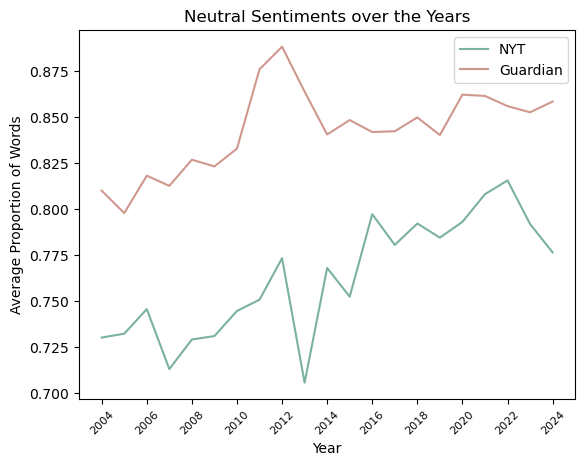

In [428]:
# neutrality by source
x = sentiment_avgs['Year']
y1 = sentiment_avgs['nyt_neut']
y2 = sentiment_avgs['g_neut']
plt.plot(x, y1, label='NYT', color='#7AB29C')
plt.plot(x, y2, label='Guardian', color='#cf988d')

plt.title("Neutral Sentiments over the Years")
plt.xlabel('Year')
plt.ylabel('Average Proportion of Words')
plt.legend(["NYT", "Guardian"])
plt.xticks(range(2004, 2025, 2), rotation=45, fontsize=8)